In [1]:
import tkinter as tk
from tkinter import filedialog
import os
import re
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from scipy.ndimage import gaussian_filter
import random
from scipy.signal import find_peaks
from scipy.ndimage import binary_dilation
from scipy.ndimage import median_filter
from scipy.ndimage import uniform_filter
import math
from scipy.signal import find_peaks, peak_prominences
from scipy.signal import peak_widths

In [2]:
# crops by 1st and last trough
def crop_image(image):

    # gets brightness values
    global_mean_signal = np.mean(image, axis=(1, 2))

    # smooths significantly along z axis
    smoothed_signal = gaussian_filter(global_mean_signal, sigma=11, mode='reflect')

    # inverts
    inverted_signal = -smoothed_signal

    # gets trough positions
    trough_indices = find_peaks(inverted_signal)
    trough_indices = trough_indices[0] # removes metadata from find_peaks

    # slices the global image by these positions
    cropped_image = image[trough_indices[0]+1:trough_indices[-1]]

    return cropped_image

In [3]:
def trim_image(image, roi_size, section_size):
    
    # Calculate new dimensions that are divisible by roi_size
    z, y, x = image.shape
    new_y = y - (y % roi_size)
    new_x = x - (x % roi_size)

    # Trim the image if necessary
    trimmed_image = image[:, :new_y, :new_x]

    # saves info about size of image:
    num_rois_x = x // roi_size
    num_rois_y = y // roi_size

    num_sections_x = x // section_size
    num_sections_y = y // section_size
    
    image_data = {
        'image_size_x': x,
        'image_size_y': y,
        'num_rois_x': num_rois_x,
        'num_rois_y': num_rois_y,
        'num_sections_x': num_sections_x,
        'num_sections_y': num_sections_y,
    }

    return trimmed_image, image_data

In [4]:
def get_rois(image, roi_size):

    # Calculate new dimensions that are divisible by area_size
    z, y, x = image.shape
    new_y = y - (y % roi_size)
    new_x = x - (x % roi_size)

    # Trim the image if necessary
    image = image[:, :new_y, :new_x]

    # gets number of rois
    image_z, image_y, image_x = image.shape
    num_rois_x = image_x // roi_size
    num_rois_y = image_y // roi_size

    # reshapes array
    reshaped_data = image.reshape(image_z, num_rois_y, roi_size, num_rois_x, roi_size)
    roi_means = np.mean(reshaped_data, axis=(2, 4))
    
    # collapses x and y
    roi_array = roi_means.reshape(image_z, num_rois_y * num_rois_x)
    
    roi_data = {}
    roi_index = 0
    
    # Iterate over each ROI
    for i in range(num_rois_y):
        for j in range(num_rois_x):
            
            # Calculate ROI boundaries
            start_y = i * roi_size
            end_y = (i + 1) * roi_size
            start_x = j * roi_size
            end_x = (j + 1) * roi_size

            # calculate ROI mid positions
            midpoint_x = (start_x+end_x)/2
            midpoint_y = (start_y+end_y)/2
            
            roi_data[roi_index] = {
                'roi_index': roi_index,
                'start_y': start_y,
                'end_y': end_y,
                'start_x': start_x,
                'end_x': end_x,
                'midpoint_x': midpoint_x,
                'midpoint_y': midpoint_y,
            }
            
            roi_index += 1

    return roi_data, roi_array

In [5]:
def standardise_signals(signals):
    # standardise before cross correlation
    means = np.mean(signals, axis=0, keepdims=True)
    stds = np.std(signals, axis=0, keepdims=True)

    # Ensure that stds are not zero to avoid division by zero
    stds[stds == 0] = 1
    signals_standardised = (signals - means) / stds
    return signals_standardised

In [6]:
def xcorr_sections(section_signals_standardised):

    # gets lag offset
    signal_length = section_signals_standardised.shape[0]
    lag_offset = signal_length - 1

    # initiates xcorr matrix
    num_sections = section_signals_standardised.shape[1]
    section_coeff_matrix = np.zeros((num_sections, num_sections))
    section_lag_matrix = np.zeros((num_sections, num_sections))
    
    for section_index in range(num_sections):

        # gets roi signal
        section_signal = section_signals_standardised[:, section_index]
        
        for other_section_index in range(section_index + 1, num_sections):  # upper matrix filled only

            # gets other roi signal   
            other_section_signal = section_signals_standardised[:, other_section_index]

            # Compute cross-correlation 
            corr = np.correlate(section_signal, other_section_signal, mode='full')

            # Find the lag corresponding to the max correlation
            lag = np.argmax(corr) - lag_offset

            # shifts the other roi signal
            other_section_signal_shifted = np.roll(other_section_signal, lag)

            # gets the pearsons' r between roi and shifted other roi signals and stores in matrix
            section_coeff_matrix[section_index, other_section_index] = np.corrcoef(other_section_signal_shifted, section_signal)[0, 1]

            # Store the lag in the matrix
            section_lag_matrix[section_index, other_section_index] = lag

    return section_coeff_matrix, section_lag_matrix

In [7]:
# gets a list of potential rois that are near sections
def get_included_rois(roi_signals_standardised, roi_data, section_data, roi_size, section_clusters):
    
    for roi_index, roi_datum in roi_data.items():
        is_in_section = roi_datum.get('is_in_section', False)
        if is_in_section == False:
            for section_cluster, cluster_sections in section_clusters.items():
                for section_index in cluster_sections:
                    section_datum = section_data[section_index]

                    difference_in_space_x = abs(roi_datum['midpoint_x'] - section_datum['midpoint_x'])
                    difference_in_space_y = abs(roi_datum['midpoint_y'] - section_datum['midpoint_y'])
                    difference_in_space_hypotenuse = math.sqrt(difference_in_space_x**2 + difference_in_space_y**2)

                    if difference_in_space_hypotenuse < (math.sqrt(roi_size**2 + roi_size**2)*4):
                        if section_cluster not in roi_data[roi_index]:
                            roi_data[roi_index][section_cluster] = {}
                        roi_data[roi_index][section_cluster]['is_in_section'] = True

    return roi_data

In [8]:
# cross correlates all local rois
def xcorr_rois(roi_signals_standardised, roi_data, section_cluster, roi_size):

    # gets lag offset
    signal_length = roi_signals_standardised.shape[0]
    lag_offset = signal_length - 1

    # initiates xcorr matrix
    num_rois = roi_signals_standardised.shape[1]
    coeff_matrix = np.zeros((num_rois, num_rois))
    lag_matrix = np.zeros((num_rois, num_rois))
    
    for roi_index in range(num_rois):

        roi_datum = roi_data[roi_index]
        roi_is_in_section = roi_datum.get(section_cluster, {}).get('is_in_section', False)
        if roi_is_in_section == True:

            # gets roi signal
            roi_signal = roi_signals_standardised[:, roi_index]
        
            for other_roi_index in range(roi_index + 1, num_rois):  # upper matrix filled only

                other_roi_datum = roi_data[other_roi_index]

                # gets difference in space
                difference_in_space_x = abs(roi_datum['midpoint_x'] - other_roi_datum['midpoint_x'])
                difference_in_space_y = abs(roi_datum['midpoint_y'] - other_roi_datum['midpoint_y'])
                difference_in_space_hypotenuse = math.sqrt(difference_in_space_x**2 + difference_in_space_y**2)
                    
                if difference_in_space_hypotenuse < roi_size*7:
                        
                    # gets other roi signal   
                    other_roi_signal = roi_signals_standardised[:, other_roi_index]

                    # Compute cross-correlation 
                    corr = np.correlate(roi_signal, other_roi_signal, mode='full')

                    # Find the lag corresponding to the max correlation
                    lag = np.argmax(corr) - lag_offset

                    # shifts the other roi signal
                    other_roi_signal_shifted = np.roll(other_roi_signal, lag)

                    # gets the pearsons' r between roi and shifted other roi signals and stores in matrix
                    coeff_matrix[roi_index, other_roi_index] = np.corrcoef(other_roi_signal_shifted, roi_signal)[0, 1]

                    # Store the lag in the matrix
                    lag_matrix[roi_index, other_roi_index] = lag

    return coeff_matrix, lag_matrix

In [9]:
def get_section_clusters(image_data, roi_data, coeff_matrix):
    plt.figure(figsize=(9, 3))
    plt.gca().set_facecolor('black')
    G = nx.Graph()
    
    # identifies pairs of rois with high r
    high_coeff_indices = np.where(np.triu(coeff_matrix, k=1) > 0.9)

    # creates a list of pairs of connected nodes
    connected_rois = list(zip(high_coeff_indices[0], high_coeff_indices[1]))

    # gets just the roi indices from this
    connected_roi_indices = np.array(connected_rois).flatten()
    # just the unique rois
    connected_roi_unique_indices = np.unique(connected_roi_indices)

    # Add all edges at once
    G.add_edges_from(connected_rois)

    # initialises euclidean position for connected rois
    pos = {}    
    image_size_x = image_data['image_size_x']
    image_size_y = image_data['image_size_y']
    for roi_index in connected_roi_unique_indices:
        midpoint_x = (roi_data[roi_index]['midpoint_x']/image_size_x)
        midpoint_y = 1.0 - (roi_data[roi_index]['midpoint_y']/image_size_y)
        pos[roi_index] = (midpoint_x, midpoint_y)

    community_colors = {
    "cluster_1": "cyan",
    "cluster_2": "lightgreen",
    "cluster_3": "LightCoral",
    "cluster_4": "lightblue",
    "cluster_5": "lime",
    "cluster_6": "chartreuse",
    "cluster_7": "hotpink",
    "cluster_8": "silver",
    "cluster_9": "magenta",
    "cluster_10": "red",
    "cluster_11": "pink",
    "cluster_12": "orange",
    "cluster_13": "blue",
    "cluster_14": "green",
    "cluster_15": "purple",
    }
    
    # get clusters
    connected_components = list(nx.connected_components(G))

    # Assign names to communities
    roi_clusters = {}
    for cluster_index, rois in enumerate(connected_components):
        roi_clusters[f"cluster_{cluster_index+1}"] = rois

    cluster_roi_counts = {cluster_name: len(rois) for cluster_name, rois in roi_clusters.items()}

    # Rank communities by number of nodes
    ranked_clusters = sorted(cluster_roi_counts.items(), key=lambda x: x[1], reverse=True)

    for cluster_index, (cluster_name, rois) in enumerate(ranked_clusters):
        new_name = f"cluster_{cluster_index+1}"
        roi_clusters[new_name] = roi_clusters.pop(cluster_name)

    print("roi_clusters:", roi_clusters)

    #nx.draw_networkx_nodes(G, pos, node_color="cyan", node_size=10)

    for node, data in G.nodes(data=True):
        for community, nodes in roi_clusters.items():
            if node in nodes:
                color = community_colors.get(community, 'red')
                nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=color, node_size=10)

    # ensures grid full size
    grid_positions = {'a': (0, 0), 'b': (0, 1), 'c': (1, 0), 'd': (1, 1)}
    pos.update(grid_positions)
    additional_nodes = ['a', 'b', 'c', 'd']
    nx.draw_networkx_nodes(G, pos, nodelist=additional_nodes, node_color='black', node_size=1)
    
    plt.show()

    included_rois = []
    for roi_index, data in G.nodes(data=True):
        included_rois.append(roi_index)
    included_rois = list(set(included_rois))
    
    return roi_clusters

In [10]:
def get_roi_clusters(image_data, roi_data, coeff_matrix):
    plt.figure(figsize=(9, 3))
    plt.gca().set_facecolor('black')
    G = nx.Graph()
    
    # identifies pairs of rois with high r
    high_coeff_indices = np.where(np.triu(coeff_matrix, k=1) > 0.9)

    # creates a list of pairs of connected nodes
    connected_rois = list(zip(high_coeff_indices[0], high_coeff_indices[1]))

    # gets just the roi indices from this
    connected_roi_indices = np.array(connected_rois).flatten()
    # just the unique rois
    connected_roi_unique_indices = np.unique(connected_roi_indices)

    # Add all edges at once
    G.add_edges_from(connected_rois)

    for roi_index, other_roi_index in connected_rois:
        if G.has_edge(roi_index, other_roi_index):
            pairwise_coeff = coeff_matrix[roi_index, other_roi_index]
            normalized_coeff = ((pairwise_coeff - 0.9) / 0.1)**10
            G.edges[(roi_index, other_roi_index)]['edge_alpha'] = normalized_coeff

    # initialises euclidean position for connected rois
    pos = {}    
    image_size_x = image_data['image_size_x']
    image_size_y = image_data['image_size_y']
    for roi_index in connected_roi_unique_indices:
        midpoint_x = (roi_data[roi_index]['midpoint_x']/image_size_x)
        midpoint_y = 1.0 - (roi_data[roi_index]['midpoint_y']/image_size_y)
        pos[roi_index] = (midpoint_x, midpoint_y)

    community_colors = {
    "cluster_1": "cyan",
    "cluster_2": "lightgreen",
    "cluster_3": "LightCoral",
    "cluster_4": "lightblue",
    "cluster_5": "lime",
    "cluster_6": "chartreuse",
    "cluster_7": "hotpink",
    "cluster_8": "silver",
    "cluster_9": "magenta",
    "cluster_10": "red",
    "cluster_11": "pink",
    "cluster_12": "orange",
    "cluster_13": "blue",
    "cluster_14": "green",
    "cluster_15": "purple",
    }
    
    # get clusters
    connected_components = list(nx.connected_components(G))

    # Assign names to communities
    roi_clusters = {}
    for cluster_index, rois in enumerate(connected_components):
        roi_clusters[f"cluster_{cluster_index+1}"] = rois

    cluster_roi_counts = {cluster_name: len(rois) for cluster_name, rois in roi_clusters.items()}

    # Rank communities by number of nodes
    ranked_clusters = sorted(cluster_roi_counts.items(), key=lambda x: x[1], reverse=True)

    for cluster_index, (cluster_name, rois) in enumerate(ranked_clusters):
        new_name = f"cluster_{cluster_index+1}"
        roi_clusters[new_name] = roi_clusters.pop(cluster_name)

    #print("roi_clusters:", roi_clusters)

    #nx.draw_networkx_nodes(G, pos, node_color="cyan", node_size=10)

    for node, data in G.nodes(data=True):
        for community, nodes in roi_clusters.items():
            if node in nodes:
                color = 'cyan'
                nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='none', node_size=1)

    edge_alphas = [data['edge_alpha'] for u, v, data in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edgelist=connected_rois, edge_color='cyan', width=1, alpha=edge_alphas)
    
    # ensures grid full size
    grid_positions = {'a': (0, 0), 'b': (0, 1), 'c': (1, 0), 'd': (1, 1)}
    pos.update(grid_positions)
    additional_nodes = ['a', 'b', 'c', 'd']
    nx.draw_networkx_nodes(G, pos, nodelist=additional_nodes, node_color='black', node_size=1)
    
    plt.show()

    included_rois = []
    for roi_index, data in G.nodes(data=True):
        included_rois.append(roi_index)
    included_rois = list(set(included_rois))
    
    return included_rois


In [11]:
def visualise_array(array, image_data):
    num_rois_x = image_data['num_rois_x']
    num_rois_y = image_data['num_rois_y']
    array_reshaped = array.reshape((num_rois_y, num_rois_x))

    plt.imshow(array_reshaped, cmap='viridis')  # 'viridis' is a good colormap for visualizing differences
    plt.colorbar()  # Show a color bar indicating the scale of standard deviations
    plt.show()


In [12]:
def get_community_signals(roi_signals, community_names):
    for community, rois in community_names.items():
        community_rois = rois
        community_signals = roi_signals[:, list(community_rois)]
        average_signal_community = np.mean(community_signals, axis=1)
        
        plt.plot(average_signal_community)
        plt.xlabel('Time')
        plt.ylabel('Average Signal')
        plt.title(f'Average ROI Signal for {community}')
        plt.show()

In [13]:
def create_community_mask(community_rois, roi_data, image_shape):
    # Initialize an empty mask for the entire image
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    # Iterate over each ROI in the community
    for roi_index in community_rois:
        # Get the ROI data
        roi_info = roi_data[roi_index]
        start_y, end_y = roi_info['start_y'], roi_info['end_y']
        start_x, end_x = roi_info['start_x'], roi_info['end_x']
        
        # Set the color to 1 for pixels within the current ROI
        mask[start_y:end_y, start_x:end_x] = 1
    
    return mask

In [14]:
def get_pixels(image, included_rois, roi_data, image_locals, roi_size):
    # lag offset for shifting
    signal_length = image.shape[0]
    lag_offset = signal_length - 1

    # initiates pixel mask
    pixel_coeff_mask = np.zeros((image.shape[1], image.shape[2]), dtype=float)
    pixel_binary_mask = np.zeros((image.shape[1], image.shape[2]), dtype=float)
    
    # for each roi in cluster
    for roi_index in included_rois:
            
        # gets roi coordinates
        roi_datum = roi_data[roi_index]
        start_y, end_y = roi_datum['start_y'], roi_datum['end_y']
        start_x, end_x = roi_datum['start_x'], roi_datum['end_x']

        # expands pixel inclusion area (but not beyond edges of image)
        expanded_border = (roi_size*2)
        expanded_start_y = max(start_y - expanded_border, 0)
        expanded_end_y = min(end_y + expanded_border, image.shape[1])
        expanded_start_x = max(start_x - expanded_border, 0)
        expanded_end_x = min(end_x + expanded_border, image.shape[2])

        # gets nearby signal
        #roi_signal = roi_signals_standardised[:, roi_index]

        max_coeff = 0
        min_coeff = 0

        # cross correlate each pixel with roi_signal, to get lag
        for y in range(expanded_start_y, expanded_end_y):
            for x in range(expanded_start_x, expanded_end_x):

                # only cross correlates if a pixel has not already been added to the mask
                # or if it has been added with a low value (try to improve)
                if pixel_coeff_mask[y, x] == 0:
                    pixel_signal = image[:, y, x]
                    pixel_signal_local = image_locals[:, y, x]

                    corr = np.correlate(pixel_signal, pixel_signal_local, mode='full')
        
                    # Find the lag corresponding to the max correlation and shifts the pixel signal
                    lag = np.argmax(corr) - lag_offset
                    pixel_shifted_signal = np.roll(pixel_signal, lag)

                    # gets the pearsons' r of each shifted pixel with its roi
                    correlation_coef = np.corrcoef(pixel_shifted_signal, pixel_signal_local)[0, 1]

                    if correlation_coef > max_coeff:
                        max_coeff = correlation_coef
                        
                    if correlation_coef < min_coeff:
                        min_coeff = correlation_coef

                    pixel_coeff_mask[y, x] = correlation_coef

                    if correlation_coef > 0.5:
                        pixel_binary_mask[y, x] = 1 

    print("max_coeff:", max_coeff)
    print("min_coeff:", min_coeff)
    
    return pixel_coeff_mask, pixel_binary_mask

In [15]:
def get_cluster_signal(pixel_mask_binary, image_trimmed):
    # makes mask 3d
    mask_3d = np.expand_dims(pixel_mask_binary, axis=0)
    mask_3d = np.repeat(mask_3d, image_trimmed.shape[0], axis=0)

    # gets mean by summation and dividing by included pixel number:
    sum_of_pixels = np.sum(image_trimmed * mask_3d, axis=(1, 2))
    num_pixels = np.sum(mask_3d, axis=(1, 2))
    num_pixels[num_pixels == 0] = 1 # to avoid divide by zero
    cluster_signal = sum_of_pixels / num_pixels

    cluster_signal_mean = np.mean(cluster_signal, keepdims=True)
    cluster_signal_max = np.max(cluster_signal)
    cluster_signal_min = np.min(cluster_signal)
    cluster_signal_range = cluster_signal_max - cluster_signal_min
    cluster_signal_stndev = np.std(cluster_signal, keepdims=True)
    cluster_signal_standardised = (cluster_signal-cluster_signal_mean)/cluster_signal_stndev

    height = cluster_signal_range * 0.3
    prominence = cluster_signal_range * 0.3
    threshold = cluster_signal_range * 0.1

    cluster_signal_zs, properties = find_peaks(cluster_signal,
                                                   height=height,
                                                   prominence=prominence,
                                                   threshold=threshold
                                                  )

    return cluster_signal, cluster_signal_standardised, cluster_signal_zs

In [16]:
def get_pixel_lag(image, cluster_rois, pixel_coeff_mask, roi_data, cluster_signal, cluster_signal_zs, roi_size):
    # lag offset for shifting
    signal_length = image.shape[0]
    lag_offset = signal_length - 1

    # initiates pixel mask
    pixel_lag_mask = np.full((image.shape[1], image.shape[2]), np.nan)
    pixel_lag_mask2 = np.full((image.shape[1], image.shape[2]), np.nan)
    
    max_lag = 0
    min_lag = 0

    max_pixel_coeff_mask = np.max(pixel_coeff_mask)
    print("max_pixel_coeff_mask:", max_pixel_coeff_mask)

    all_pixel_lags = []
    
    # for each roi in cluster
    for roi_index in cluster_rois:

        # gets roi coordinates
        roi_datum = roi_data[roi_index]
        start_y, end_y = roi_datum['start_y'], roi_datum['end_y']
        start_x, end_x = roi_datum['start_x'], roi_datum['end_x']
        
        # expands pixel inclusion area (but not beyond edges of image)
        expanded_border = (roi_size*2)
        expanded_start_y = max(start_y - expanded_border, 0)
        expanded_end_y = min(end_y + expanded_border, image.shape[1])
        expanded_start_x = max(start_x - expanded_border, 0)
        expanded_end_x = min(end_x + expanded_border, image.shape[2])
            
        # cross correlate each pixel with roi_signal, to get lag
        for y in range(expanded_start_y, expanded_end_y):
            for x in range(expanded_start_x, expanded_end_x):

                # only cross correlates if a pixel has not already been added to the mask
                # or if it has been added with a low value (try to improve)
                if pixel_coeff_mask[y, x] != 0 and np.isnan(pixel_lag_mask[y, x]):

                    corr = np.correlate(image[:, y, x,], cluster_signal, mode='full')
        
                    # Find the lag corresponding to the max correlation and shifts the pixel signal
                    lag = np.argmax(corr) - lag_offset
                              
                    if lag > max_lag:
                        max_lag = lag

                    if lag < min_lag:
                        min_lag = lag
                    
                    # saves to mask
                    pixel_lag_mask[y, x] = lag

                    # saves to list to get IQR
                    all_pixel_lags.append(lag)

    # Calculate IQR * 1.5 thresholds
    all_pixel_lags_array = np.array(all_pixel_lags)
    Q1 = np.percentile(all_pixel_lags, 25)
    Q3 = np.percentile(all_pixel_lags, 75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    plt.hist(all_pixel_lags, bins=10, color='skyblue', edgecolor='black')
    plt.xlabel('Pixel Lags')
    plt.ylabel('Frequency')
    plt.title('Histogram of All Pixel Lags')
    plt.axvline(lower_threshold, color='red', linestyle='dashed', linewidth=1, label='Lower Threshold')
    plt.axvline(upper_threshold, color='red', linestyle='dashed', linewidth=1, label='Upper Threshold')
    plt.legend()
    plt.show()

    unique_values, frequencies = np.unique(all_pixel_lags, return_counts=True)

    # Plot bar chart
    plt.bar(unique_values, frequencies, color='skyblue', edgecolor='black')
    plt.xlabel('Pixel Lags')
    plt.ylabel('Frequency')
    plt.title('Bar Chart of Pixel Lags and Frequencies')
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
    plt.show()

    max_thresholded_lag = 0
    min_thresholded_lag = 0
    
    # clips within 1.5x interquartile range
    for roi_index in cluster_rois:

        # gets roi coordinates
        roi_datum = roi_data[roi_index]
        start_y, end_y = roi_datum['start_y'], roi_datum['end_y']
        start_x, end_x = roi_datum['start_x'], roi_datum['end_x']

        expanded_border = (roi_size*2)
        expanded_start_y = max(start_y - expanded_border, 0)
        expanded_end_y = min(end_y + expanded_border, image.shape[1])
        expanded_start_x = max(start_x - expanded_border, 0)
        expanded_end_x = min(end_x + expanded_border, image.shape[2])
        
        for y in range(expanded_start_y, expanded_end_y):
            for x in range(expanded_start_x, expanded_end_x):
                if not np.isnan(pixel_lag_mask[y, x]):
                    if pixel_lag_mask[y, x] > upper_threshold:
                        pixel_lag_mask[y, x] = upper_threshold
                    if pixel_lag_mask[y, x] < lower_threshold:
                        pixel_lag_mask[y, x] = lower_threshold
                        
                    if pixel_lag_mask[y, x] > max_thresholded_lag:
                        max_thresholded_lag = pixel_lag_mask[y, x]
                        print("threshold increased")
                    if pixel_lag_mask[y, x] < min_thresholded_lag:
                        min_thresholded_lag = pixel_lag_mask[y, x]
                        print("threshold decreased")

    print("max_lag:", max_lag)
    print("min_lag:", min_lag)
    print("max_thresholded_lag:", max_thresholded_lag)
    print("min_thresholded_lag:", min_thresholded_lag)
    print("lower_threshold:", lower_threshold)
    print("upper_threshold:", upper_threshold)
    print("lag stndev:", np.std(all_pixel_lags_array))
    print("all lags:", all_pixel_lags_array)
    print("pixel_lag_mask lags:", pixel_lag_mask)
    
    return pixel_lag_mask, max_thresholded_lag, min_thresholded_lag

In [17]:
def get_roitocluster_lag(included_rois, roi_signals_standardised, cluster_signal_standardised):
    signal_length = len(cluster_signal_standardised)
    lag_offset = signal_length - 1
    roi_tocluster_lags = {}
    all_lags = []
    for roi_index in included_rois:
        roi_signal = roi_signals_standardised[:, roi_index]
        corr = np.correlate(roi_signal, cluster_signal_standardised, mode='full')
        
        lag = np.argmax(corr) - lag_offset

        roi_tocluster_lags[roi_index] = lag  
        all_lags.append(lag)
    all_lags_max = np.max(all_lags)
    all_lags_min = np.min(all_lags)
    return roi_tocluster_lags, all_lags_max, all_lags_min

In [18]:
def plot_velocity_map(roi_tocluster_lags, roi_data, image_data, roi_size, all_lags_max, all_lags_min):
    plt.figure(figsize=(9, 3))
    plt.gca().set_facecolor('black')
    G = nx.Graph()
    
    for roi_index, roi_tocluster_lag in roi_tocluster_lags.items():
        for other_roi_index, other_roi_tocluster_lag in roi_tocluster_lags.items():
            if roi_index > other_roi_index:

                # gets difference in space
                roi_datum = roi_data[roi_index]
                other_roi_datum = roi_data[other_roi_index]
                difference_in_space_x = abs(roi_datum['midpoint_x'] - other_roi_datum['midpoint_x'])
                difference_in_space_y = abs(roi_datum['midpoint_y'] - other_roi_datum['midpoint_y'])
                difference_in_space_hypotenuse = math.sqrt(difference_in_space_x**2 + difference_in_space_y**2)

                if difference_in_space_hypotenuse < roi_size*4:
                    
                    G.add_edge(roi_index, other_roi_index)
                    lag_difference = abs(roi_tocluster_lag - other_roi_tocluster_lag)
                    lag_difference_modified = 1-((lag_difference - all_lags_min) / (all_lags_max - all_lags_min))
                    G.edges[(roi_index, other_roi_index)]['lag_diff'] = lag_difference_modified
                    
    # initialises euclidean position for connected rois
    pos = {}    
    image_size_x = image_data['image_size_x']
    image_size_y = image_data['image_size_y']
    for roi_index, roi_tocluster_lag in roi_tocluster_lags.items():
        midpoint_x = (roi_data[roi_index]['midpoint_x']/image_size_x)
        midpoint_y = 1.0 - (roi_data[roi_index]['midpoint_y']/image_size_y)
        pos[roi_index] = (midpoint_x, midpoint_y)
        
    # paints nodes, edges and labels
    for node, data in G.nodes(data=True):
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='none', node_size=1)
        break  
    for source, target, data in G.edges(data=True):
        nx.draw_networkx_edges(G,
                               pos,
                               edgelist=[(source, target)],
                               edge_color=plt.cm.viridis(data['lag_diff']),
                               width=1,
                               alpha=data['lag_diff'])
    # ensures grid full size
    grid_positions = {'a': (0, 0), 'b': (0, 1), 'c': (1, 0), 'd': (1, 1)}
    pos.update(grid_positions)
    additional_nodes = ['a', 'b', 'c', 'd']
    nx.draw_networkx_nodes(G, pos, nodelist=additional_nodes, node_color='black', node_size=1)
    
    plt.show()

In [19]:
def get_included_rois_signal(included_rois, roi_signals_standardised):

    included_roi_signals_sum = None
    num_included_roi_signals = 0
    for roi_index in included_rois:
        included_roi_signal = roi_signals_standardised[:, roi_index]
        num_included_roi_signals += 1
        if included_roi_signals_sum is not None:
            included_roi_signals_sum = included_roi_signals_sum + included_roi_signal
        else:
            included_roi_signals_sum = included_roi_signal

    included_roi_signals_mean = (included_roi_signals_sum/num_included_roi_signals)
    return included_roi_signals_mean

In [20]:
def analyse_intervals(cluster_signal):
    from scipy.signal import find_peaks, peak_prominences

    smoothed_cluster_signal = gaussian_filter(cluster_signal, sigma=3, mode='reflect')

    # gets smoothed_cluster_signal range
    smoothed_cluster_signal_max = np.max(smoothed_cluster_signal)
    smoothed_cluster_signal_min = np.min(smoothed_cluster_signal)
    smoothed_cluster_signal_range = smoothed_cluster_signal_max - smoothed_cluster_signal_min

    # differentiates hypersmoothed
    diff_smoothed_signal = np.diff(smoothed_cluster_signal)

    # peak search parameters:
    # HEIGHT: peak must be above n% the range
    height = (0.3 * smoothed_cluster_signal_range) + smoothed_cluster_signal_min

    # PROMINENCE: min prominence is n*range
    prominence = (0.3 * smoothed_cluster_signal_range)

    # THRESHOLD: 10% of the range
    max_threshold = 0.1 * smoothed_cluster_signal_range
    threshold = (0, max_threshold)
   
    # finds peaks in hypersmoothed    
    smoothed_peak_zs, properties = find_peaks(smoothed_cluster_signal,
                                                   height=height,
                                                   prominence=prominence,
                                                   threshold=threshold
                                                  )
   
    # gets peak widths
    smoothed_peak_widths = peak_widths(smoothed_cluster_signal, smoothed_peak_zs, rel_height=0.75)

    cluster_peak_zs = []
    cluster_peak_heights = []
    cluster_dvdtmax_zs = []
    cluster_dvdtmax_heights = []
    cluster_dvdtmin_zs = []
    cluster_dvdtmin_heights = []
    cluster_dvdtmax_displacements = []
    cluster_dvdtmin_displacements = []
    cluster_dvdtmaxs = []
    cluster_dvdtmins = []
    cluster_peak_prominences = []
    for smoothed_peak_z in smoothed_peak_zs:

        # defines window to search in using 'distance' (max and min to ensure doesn't go beyond ranges of z)
        search_window_peak_start_z = max(0, smoothed_peak_z - 2)
        search_window_peak_end_z = min(len(cluster_signal), smoothed_peak_z + 2)
        search_window_peak = cluster_signal[search_window_peak_start_z:search_window_peak_end_z]

        # argmax returns z position of max amplitude within windowed signal
        window_peak_z = np.argmax(search_window_peak)
        cluster_peak_z = window_peak_z + search_window_peak_start_z
        cluster_peak_zs.append(cluster_peak_z)

        # gets heights at these z positions in original signal
        cluster_peak_height = cluster_signal[cluster_peak_z]
        cluster_peak_heights.append(cluster_peak_height)

        # gets peak width to determine index
        smoothed_peak_width_index = np.where(smoothed_peak_zs == smoothed_peak_z)[0][0]
        smoothed_peak_width = smoothed_peak_widths[0][smoothed_peak_width_index]

        # sets a broader window to find dvdt max and min
        search_window_dvd_start_z = max(0, smoothed_peak_z - (int(smoothed_peak_width // 2)))
        search_window_dvd_end_z = min(len(cluster_signal)-1, smoothed_peak_z + (int(smoothed_peak_width // 2)))
        search_window_dvdt = diff_smoothed_signal[search_window_dvd_start_z:search_window_dvd_end_z]
       
        # finds dvdtmax and dvdtmin value within this window
        window_dvdtmax_z = np.argmax(search_window_dvdt)
        window_dvdtmin_z = np.argmin(search_window_dvdt)
        cluster_dvdtmax_z = window_dvdtmax_z + search_window_dvd_start_z + 1
        cluster_dvdtmin_z = window_dvdtmin_z + search_window_dvd_start_z + 1
        cluster_dvdtmax_zs.append(cluster_dvdtmax_z)
        cluster_dvdtmin_zs.append(cluster_dvdtmin_z)

        # finds dvdt displacements
        cluster_dvdtmax_displacement = abs(cluster_peak_z - cluster_dvdtmax_z)
        cluster_dvdtmin_displacement = abs(cluster_peak_z - cluster_dvdtmin_z)
        cluster_dvdtmax_displacements.append(cluster_dvdtmax_displacement)
        cluster_dvdtmin_displacements.append(cluster_dvdtmin_displacement)
       
        # gets heights at these z positions in hypersmoothed signal
        cluster_dvdtmax_height = smoothed_cluster_signal[cluster_dvdtmax_z]
        cluster_dvdtmin_height = smoothed_cluster_signal[cluster_dvdtmin_z]
        cluster_dvdtmax_heights.append(cluster_dvdtmax_height)
        cluster_dvdtmin_heights.append(cluster_dvdtmin_height)

        # gets dvdt values at these z positions
        cluster_dvdtmax = search_window_dvdt[window_dvdtmax_z]
        cluster_dvdtmin = search_window_dvdt[window_dvdtmin_z]
        cluster_dvdtmaxs.append(cluster_dvdtmax)
        cluster_dvdtmins.append(cluster_dvdtmin)

        # finds min value around peak, and uses this to get height
        search_window_prominence_start_z = max(0, cluster_peak_z - (int(smoothed_peak_width *1.5)))
        search_window_prominence_end_z = min(len(cluster_signal)-1, cluster_peak_z + (int(smoothed_peak_width *1.5)))
        search_window_prominence = cluster_signal[search_window_prominence_start_z:search_window_prominence_end_z]
        cluster_peak_nearby_min = np.min(search_window_prominence)
        cluster_peak_prominence = cluster_peak_height - cluster_peak_nearby_min
        cluster_peak_prominences.append(cluster_peak_prominence)
       
    # gets intervals (if more than one peak found)
    cluster_interpeak_intervals = []
    cluster_interpeak_intervals_min = None
    cluster_interpeak_intervals_max = None
    cluster_interpeak_intervals_mean = None
    cluster_interpeak_intervals_stndev = None
    cluster_interpeak_intervals_range = None
    cluster_peak_frequency = None
    cluster_dvdtmin_displacements_mean = None
    cluster_dvdtmax_displacements_mean = None
    cluster_dvdtmaxs_mean = None
    cluster_dvdtmins_mean = None
       
    if len(cluster_peak_zs) > 1:

        cluster_interpeak_intervals = [cluster_peak_zs[i+1] - cluster_peak_zs[i] for i in range(len(cluster_peak_zs)-1)]
           
        if cluster_interpeak_intervals != []: # only gets mean if not empty
            cluster_interpeak_intervals_min = np.min(cluster_interpeak_intervals)
            cluster_interpeak_intervals_max = np.max(cluster_interpeak_intervals)
            cluster_interpeak_intervals_mean = np.mean(cluster_interpeak_intervals)
            cluster_interpeak_intervals_stndev = np.std(cluster_interpeak_intervals)
            cluster_interpeak_intervals_range = cluster_interpeak_intervals_max - cluster_interpeak_intervals_min

        if cluster_interpeak_intervals_mean != 0:
            cluster_peak_frequency = 1 / cluster_interpeak_intervals_mean

        cluster_dvdtmax_displacements_mean = np.mean(cluster_dvdtmax_displacements)
        cluster_dvdtmin_displacements_mean = np.mean(cluster_dvdtmin_displacements)
        cluster_dvdtmax_mean = np.mean(cluster_dvdtmaxs)
        cluster_dvdtmin_mean = np.mean(cluster_dvdtmins)

    cluster_data = {}       
    cluster_data.update({
            'cluster_signal': cluster_signal,
            'cluster_peak_zs': cluster_peak_zs,
            'cluster_peak_frequency': cluster_peak_frequency,
            'cluster_peak_heights': cluster_peak_heights,
            'cluster_interpeak_intervals': cluster_interpeak_intervals,
            'cluster_interpeak_intervals_min': cluster_interpeak_intervals_min,
            'cluster_interpeak_intervals_max': cluster_interpeak_intervals_max,
            'cluster_interpeak_intervals_mean': cluster_interpeak_intervals_mean,
            'cluster_interpeak_intervals_stndev': cluster_interpeak_intervals_stndev,
            'cluster_interpeak_intervals_range': cluster_interpeak_intervals_range,
            'cluster_dvdtmax_zs': cluster_dvdtmax_zs,
            'cluster_dvdtmax_heights': cluster_dvdtmax_heights,
            'cluster_dvdtmin_zs': cluster_dvdtmin_zs,
            'cluster_dvdtmin_heights': cluster_dvdtmin_heights,
            'cluster_dvdtmax_displacements': cluster_dvdtmax_displacements,
            'cluster_dvdtmin_displacements': cluster_dvdtmin_displacements,
            'cluster_dvdtmax_displacements_mean': cluster_dvdtmax_displacements_mean,
            'cluster_dvdtmaxs': cluster_dvdtmaxs,
            'cluster_dvdtmaxs_mean': cluster_dvdtmaxs_mean,
            'cluster_dvdtmins_mean': cluster_dvdtmins_mean,
            'cluster_peak_prominences': cluster_peak_prominences,
        })

    return cluster_data

In [21]:
def plot_cluster_signal(cluster_data):
    
    cluster_signal = cluster_data['cluster_signal']
    cluster_peak_zs = cluster_data['cluster_peak_zs']
    cluster_peak_heights = cluster_data['cluster_peak_heights']
    cluster_dvdtmax_zs = cluster_data['cluster_dvdtmax_zs']
    cluster_dvdtmax_heights = cluster_data['cluster_dvdtmax_heights']
    cluster_dvdtmin_zs = cluster_data['cluster_dvdtmin_zs']
    cluster_dvdtmin_heights = cluster_data['cluster_dvdtmin_heights']
    
    ms_per_slice = 1.708
    time_ms = np.arange(len(cluster_signal)) * ms_per_slice
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_ms, cluster_signal, marker='o', linestyle='-', markersize=1, linewidth=1, color='blue')
    plt.scatter(np.array(cluster_peak_zs) * ms_per_slice, cluster_peak_heights, color='red', s=50, marker='x', zorder=3)
    plt.scatter(np.array(cluster_dvdtmax_zs) * ms_per_slice, cluster_dvdtmax_heights, color='green', s=50, marker='x', zorder=3)
    #plt.scatter(np.array(global_dvdtmin_zs) * ms_per_slice, global_dvdtmin_heights, color='purple', s=50, marker='x', zorder=3)

    global_frequency_hz_formatted = "n/a"

    if len(cluster_peak_zs) >1:
        cluster_frequency = cluster_data['cluster_peak_frequency']
        cluster_bpm = cluster_frequency * 1/ 0.00002833333
        cluster_bpm_formatted = "{:.2f}".format(cluster_bpm)
    
        cluster_interpeak_intervals_mean = cluster_data['cluster_interpeak_intervals_mean']
        cluster_frequency_hz = 1/(cluster_interpeak_intervals_mean*0.0017)
        cluster_frequency_hz_formatted = "{:.2f}".format(cluster_frequency_hz)
    
    title = f'Cluster signal over Time\n'
    title += f'Rate: {cluster_frequency_hz_formatted} Hz\n'
    plt.title(title)
    
    plt.xlabel('Time (ms)')
    plt.ylabel('Calcium Signal amplitude (a.u.)')

    plt.xticks(np.arange(0, max(time_ms), 100))
    plt.xticks(rotation=45, fontsize=10)
    
    plt.grid(True)
    plt.show()

In [22]:
def plot_intervals_cluster(cluster_data):

    cluster_interpeak_intervals = cluster_data['cluster_interpeak_intervals']
    cluster_interpeak_intervals_ms = [interval * 1.708 for interval in cluster_interpeak_intervals]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(cluster_interpeak_intervals_ms)), cluster_interpeak_intervals_ms, marker='o', linestyle='-', color='blue', linewidth=1, markersize=5) 
    plt.xlabel('Time')
    plt.ylabel('Cluster peak intervals (ms)')

    mean_formatted = "n/a"
    stndev_formatted = "n/a"

    if len(cluster_interpeak_intervals) >1:

        mean_ms = cluster_data['cluster_interpeak_intervals_mean'] * 1.708
        stndev_ms = cluster_data['cluster_interpeak_intervals_stndev'] * 1.708
    
        mean_formatted = "{:.2f}".format(mean_ms)
        stndev_formatted = "{:.2f}".format(stndev_ms)
    
    title = f'Intervals between peaks in cluster signal\n'
    title += f'Mean interval (2dp): {mean_formatted} (ms)\n'
    title += f'Interval standard deviation (2dp): {stndev_formatted} (ms)'
    plt.title(title)

    plt.xticks([])
    
    plt.grid(True)

    plt.show()

In [23]:
def plot_diffs(cluster_signal):

    smoothed_cluster_signal = gaussian_filter(cluster_signal, sigma=3, mode='reflect')
    
    diff1_smoothed_signal = np.diff(smoothed_cluster_signal)
    diff2_smoothed_signal = np.diff(diff1_smoothed_signal)
    diff3_smoothed_signal = np.diff(diff2_smoothed_signal)

    diff1_smoothed_signal = np.delete(diff1_smoothed_signal, -1)

    plt.figure(figsize=(10, 6))
    plt.plot(diff1_smoothed_signal, diff2_smoothed_signal, marker='o', linestyle='-', color='blue', linewidth=1, markersize=1, alpha=0.25) 
    plt.xlabel('diff1_smoothed_signal')
    plt.ylabel('diff2_smoothed_signal')
    plt.show()

    diff2_smoothed_signal = np.delete(diff2_smoothed_signal, -1)

    plt.figure(figsize=(10, 6))
    plt.plot(diff2_smoothed_signal, diff3_smoothed_signal, marker='o', linestyle='-', color='blue', linewidth=1, markersize=1, alpha=0.25) 
    plt.xlabel('diff2_smoothed_signal')
    plt.ylabel('diff3_smoothed_signal')
    plt.show()

In [24]:
def analyse(tiff_image, roi_size):
    import time
    all_start_time = time.time()

    # convert to float
    image = tiff_image.astype(float)

    # trim it by 1st and last trough
    image_cropped = crop_image(image)

    # trims image to the size of rois (if roi size doesn't fit exactly)
    section_size = (roi_size *3)
    image_trimmed, image_data = trim_image(image_cropped, roi_size, section_size)

    # visualises trimmed:    
    image_trimmed_stndevs = np.std(image_trimmed, axis=0)
    plt.imshow(image_trimmed_stndevs, cmap='viridis')
    cbar = plt.colorbar(orientation='horizontal')
    cbar.set_label('Pixel standard deviation (raw image)')
    plt.show()

    # makes a smoothed version of image (for doing correlations rois and pixels)
    start_time = time.time()
    image_smoothed = gaussian_filter(image_trimmed, sigma=(5,1,1), mode='reflect')
    image_locals = uniform_filter(image_trimmed, size=(1,10,10), mode='reflect')
    end_time = time.time()
    print(f"smoothing time: {end_time - start_time} seconds")
    
    # visualises smoothed:    
    image_smoothed_stndevs = np.std(image_smoothed, axis=0)
    plt.imshow(image_smoothed_stndevs, cmap='viridis')
    cbar = plt.colorbar(orientation='horizontal')
    cbar.set_label('Pixel standard deviation (smoothed image)')
    plt.show()

    # visualises smoothed:    
    image_locals_stndevs = np.std(image_locals, axis=0)
    plt.imshow(image_locals_stndevs, cmap='viridis')
    cbar = plt.colorbar(orientation='horizontal')
    cbar.set_label('Pixel standard deviation (local area image)')
    plt.show()

    # carves out smoothed sections
    start_time = time.time()
    section_data, section_signals = get_rois(image_smoothed, section_size)
    end_time = time.time()
    print(f"get_sections time: {end_time - start_time} seconds")

    # carves out smoothed rois 
    start_time = time.time()
    roi_data, roi_signals = get_rois(image_smoothed, roi_size)
    end_time = time.time()
    print(f"get_rois time: {end_time - start_time} seconds")
    
    # visualises carved out rois:    
    roi_signals_stndev = np.std(roi_signals, axis=0)
    num_rois_x = image_data['num_rois_x']
    num_rois_y = image_data['num_rois_y']
    roi_signals_stndev_reshaped = roi_signals_stndev.reshape((num_rois_y, num_rois_x))
    plt.imshow(roi_signals_stndev_reshaped, cmap='viridis')  
    cbar = plt.colorbar(orientation='horizontal')
    cbar.set_label('ROI standard deviations')
    plt.show()

    # visualises carved out sections:    
    section_signals_stndev = np.std(section_signals, axis=0)
    num_sections_x = image_data['num_sections_x']
    num_sections_y = image_data['num_sections_y']
    section_signals_stndev_reshaped = section_signals_stndev.reshape((num_sections_y, num_sections_x))
    plt.imshow(section_signals_stndev_reshaped, cmap='viridis')  
    cbar = plt.colorbar(orientation='horizontal')
    cbar.set_label('ROI standard deviations')
    plt.show()
    
    # standardises each section signal
    start_time = time.time()
    section_signals_standardised = standardise_signals(section_signals)
    end_time = time.time()
    print(f"standardising roi signals time: {end_time - start_time} seconds")
    
    # standardises each roi signal
    start_time = time.time()
    roi_signals_standardised = standardise_signals(roi_signals)
    end_time = time.time()
    print(f"standardising roi signals time: {end_time - start_time} seconds")
    
    # standardises each pixel signal
    start_time = time.time()
    image_standardised = standardise_signals(image_smoothed)
    end_time = time.time()
    print(f"standardising pixels time: {end_time - start_time} seconds")

    # standardises each pixel signal
    start_time = time.time()
    image_locals_standardised = standardise_signals(image_locals)
    end_time = time.time()
    print(f"standardising local pixels time: {end_time - start_time} seconds")

    # obtains coeff for every section with other section:    
    start_time = time.time()
    section_coeff_matrix, section_lag_matrix = xcorr_sections(section_signals_standardised)
    end_time = time.time()
    print(f"lag_matrix time: {end_time - start_time} seconds")

    # Calculate the interquartile range (IQR)
    lag_matrix_uq = np.percentile(section_lag_matrix, 75)
    lag_matrix_lq = np.percentile(section_lag_matrix, 25)
    iqr = lag_matrix_uq - lag_matrix_lq

    # Calculate the upper and lower bounds for thresholding
    threshold_upper = lag_matrix_uq + 1.5 * iqr
    threshold_lower = lag_matrix_lq - 1.5 * iqr

    # Filter values within the threshold range
    thresholded_values = section_lag_matrix[(section_lag_matrix >= threshold_lower) & (section_lag_matrix <= threshold_upper)]
    print("max lag rois:", np.max(thresholded_values))
    print("min lag rois:", np.min(thresholded_values))

    print("section_lag_matrix:", section_lag_matrix)
    plt.imshow(section_lag_matrix, cmap='viridis')  # 'viridis' is a good colormap for visualizing differences
    plt.colorbar()  # Show a color bar indicating the scale of standard deviations
    plt.show()

    print("section_coeff_matrix:", section_coeff_matrix)
    plt.imshow(section_coeff_matrix, cmap='viridis')  # 'viridis' is a good colormap for visualizing differences
    plt.colorbar()  # Show a color bar indicating the scale of standard deviations
    plt.show()
    
    # networks the ROIs by xcorr_coeff to obtain clusters
    start_time = time.time()
    section_clusters = get_section_clusters(image_data, section_data, section_coeff_matrix)
    end_time = time.time()
    print(f"make_network time: {end_time - start_time} seconds")

    
    # gets list of rois that are inside or near section clusters
    roi_data = get_included_rois(roi_signals_standardised, roi_data, section_data, roi_size, section_clusters)
    



    # gets active pixels within each cluster
    # for each cluster, looks at each ROI to cross correlate its pixels with its ROI signal - excluding noisy pixels within ROIs
    for section_cluster, cluster_sections in section_clusters.items():

        # obtains coeff for every roi with other roi (within a section cluster):
        start_time = time.time()
        coeff_matrix, lag_matrix = xcorr_rois(roi_signals_standardised, roi_data, section_cluster, roi_size)
        end_time = time.time()
        print(f"lag_matrix time: {end_time - start_time} seconds")

        # Calculate the interquartile range (IQR)
        lag_matrix_uq = np.percentile(lag_matrix, 75)
        lag_matrix_lq = np.percentile(lag_matrix, 25)
        iqr = lag_matrix_uq - lag_matrix_lq

        # Calculate the upper and lower bounds for thresholding
        threshold_upper = lag_matrix_uq + 1.5 * iqr
        threshold_lower = lag_matrix_lq - 1.5 * iqr

        # Filter values within the threshold range
        thresholded_values = lag_matrix[(lag_matrix >= threshold_lower) & (lag_matrix <= threshold_upper)]
        print("max lag rois:", np.max(thresholded_values))
        print("min lag rois:", np.min(thresholded_values))

        print("lag_matrix:", lag_matrix)
        plt.imshow(lag_matrix, cmap='viridis')  # 'viridis' is a good colormap for visualizing differences
        plt.colorbar()  # Show a color bar indicating the scale of standard deviations
        plt.show()

        print("coeff_matrix:", coeff_matrix)
        plt.imshow(coeff_matrix, cmap='viridis')  # 'viridis' is a good colormap for visualizing differences
        plt.colorbar()  # Show a color bar indicating the scale of standard deviations
        plt.show()
    
        # networks the ROIs by xcorr_coeff to obtain clusters
        start_time = time.time()
        included_rois = get_roi_clusters(image_data, roi_data, coeff_matrix)
        end_time = time.time()
        print(f"make_network time: {end_time - start_time} seconds")

        # gets mean of all included rois
        included_roi_signals_mean = get_included_rois_signal(included_rois, roi_signals_standardised)
        plt.plot(included_roi_signals_mean)
        plt.xlabel('Time')
        plt.ylabel('Average Signal')
        plt.title(f'Average included ROI Signal for {section_cluster}')
        plt.show()

        # gets pixels that cross correlate with roi mean signal        
        start_time = time.time()
        pixel_coeff_mask, pixel_binary_mask = get_pixels(image_standardised, included_rois, roi_data, image_locals_standardised, roi_size)
        end_time = time.time()
        print(f"get_pixels time: {end_time - start_time} seconds")

        plt.imshow(pixel_coeff_mask, cmap='viridis')
        plt.title('pixel_coeff_mask')
        plt.show()

        plt.imshow(pixel_binary_mask, cmap='viridis')
        plt.title('pixel_binary_mask')
        plt.show()

        # gets the signal for the cluster (and standardises it)
        start_time = time.time()
        cluster_signal, cluster_signal_standardised, cluster_signal_zs = get_cluster_signal(pixel_binary_mask, image_trimmed)
        end_time = time.time()
        print(f"get_cluster_signal time: {end_time - start_time} seconds")

        print("cluster_signal_zs:", cluster_signal_zs)
        
        plt.plot(cluster_signal)
        plt.xlabel('Time')
        plt.ylabel('Average Signal')
        plt.title(f'Average ROI Signal for {section_cluster}')
        plt.show()



        # get list of roi diff to cluster
        #start_time = time.time()
        #roi_tocluster_lags, all_lags_max, all_lags_min = get_roitocluster_lag(included_rois, roi_signals_standardised, cluster_signal_standardised)
        #end_time = time.time()
        #print(f"get_roitocluster_lag time: {end_time - start_time} seconds")

        # plot network
        #start_time = time.time()
        #plot_velocity_map(roi_tocluster_lags, roi_data, image_data, roi_size, all_lags_max, all_lags_min)
        #end_time = time.time()
        #print(f"plot_velocity_map time: {end_time - start_time} seconds")

        # get xcorr mask of pixels to cluster - do this by roi so doing have to iterate over whole image
        start_time = time.time()
        pixel_lag_mask, max_thresholded_lag, min_thresholded_lag = get_pixel_lag(image_standardised, included_rois, pixel_coeff_mask, roi_data, cluster_signal_standardised, cluster_signal_zs, roi_size)
        end_time = time.time()
        print(f"get_pixel_lag time: {end_time - start_time} seconds")

        print("max pixel lag", np.max(pixel_lag_mask))

        norm_pixel_lag_mask = (pixel_lag_mask - min_thresholded_lag) / (max_thresholded_lag - min_thresholded_lag)
        print("max pixel norm lag", np.max(norm_pixel_lag_mask))

        absolute_difference = abs(max_thresholded_lag - min_thresholded_lag)
        coeff_scaled = pixel_coeff_mask**2
        coeff_max = np.max(coeff_scaled)
        coeff_min = np.min(coeff_scaled)
        alpha_scaled = (coeff_scaled - coeff_min) / (coeff_max - coeff_min)

        print("jet")

        cmap_reversed = mpl.cm.get_cmap('jet')
        
        fig, ax = plt.subplots(figsize=(9, 27))
        ax.set_facecolor('black')
        img = ax.imshow(norm_pixel_lag_mask, cmap=cmap_reversed)
        img.set_alpha(alpha_scaled)
        plt.title('pixel_lag_mask2')
        sm = mpl.cm.ScalarMappable(cmap=cmap_reversed, norm=plt.Normalize(vmin=0, vmax=absolute_difference))
        cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
        cbar.set_label('signal propagation lag')
        plt.show()

        cluster_data = analyse_intervals(cluster_signal)
        plot_cluster_signal(cluster_data)
        plot_intervals_cluster(cluster_data)
        plot_diffs(cluster_signal)



    all_end_time = time.time()
    print(f"all time: {all_end_time - all_start_time} seconds")

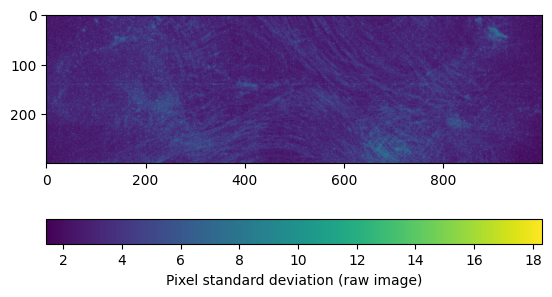

smoothing time: 4.519423246383667 seconds


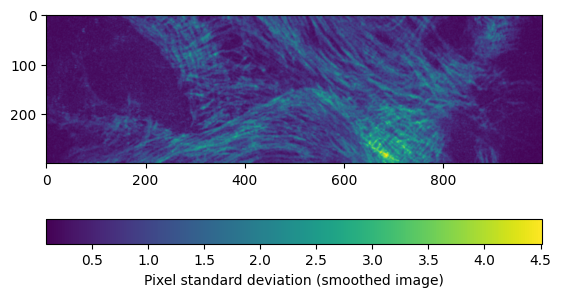

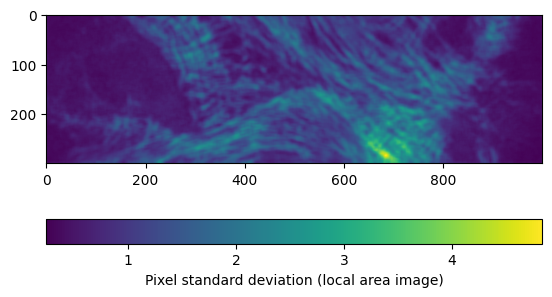

get_sections time: 0.10278677940368652 seconds
get_rois time: 0.1734464168548584 seconds


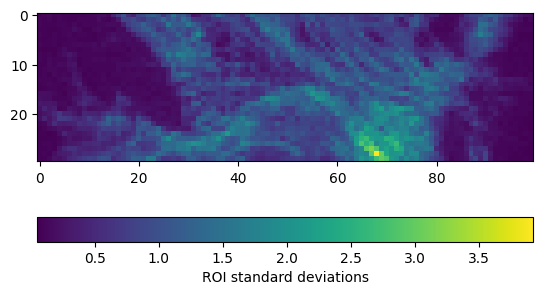

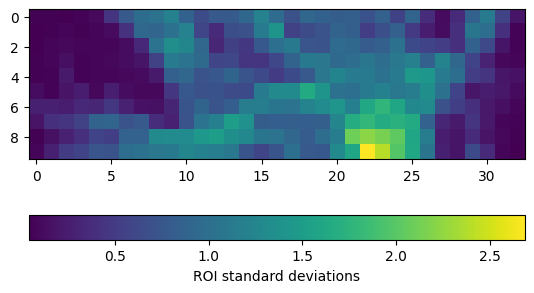

standardising roi signals time: 0.0 seconds
standardising roi signals time: 0.0 seconds
standardising pixels time: 1.5183990001678467 seconds
standardising local pixels time: 1.5104193687438965 seconds
lag_matrix time: 17.38955783843994 seconds
max lag rois: 2.0
min lag rois: -1.0
section_lag_matrix: [[   0.    0.   -3. ...   -6. -187.   -5.]
 [   0.    0.   -4. ...   -4.  -98.   -6.]
 [   0.    0.    0. ...    5.   -1.   -1.]
 ...
 [   0.    0.    0. ...    0.    0.    1.]
 [   0.    0.    0. ...    0.    0.    2.]
 [   0.    0.    0. ...    0.    0.    0.]]


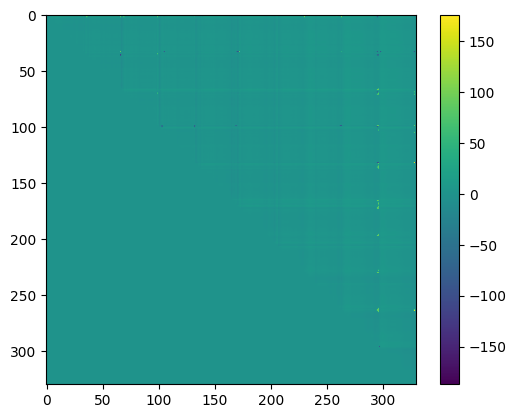

section_coeff_matrix: [[0.         0.63656609 0.4885715  ... 0.53032642 0.41629378 0.52782971]
 [0.         0.         0.56252983 ... 0.68990396 0.68653778 0.51189678]
 [0.         0.         0.         ... 0.56423486 0.41750093 0.59769994]
 ...
 [0.         0.         0.         ... 0.         0.68603054 0.76981797]
 [0.         0.         0.         ... 0.         0.         0.82503844]
 [0.         0.         0.         ... 0.         0.         0.        ]]


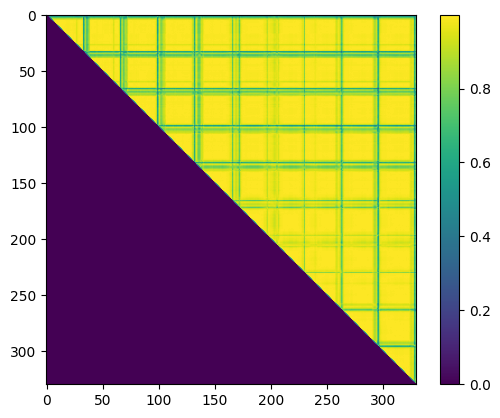

roi_clusters: {'cluster_1': {4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 

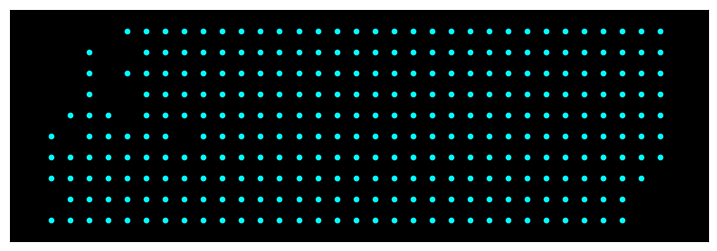

make_network time: 6.436506032943726 seconds
lag_matrix time: 69.852707862854 seconds
max lag rois: 0.0
min lag rois: 0.0
lag_matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


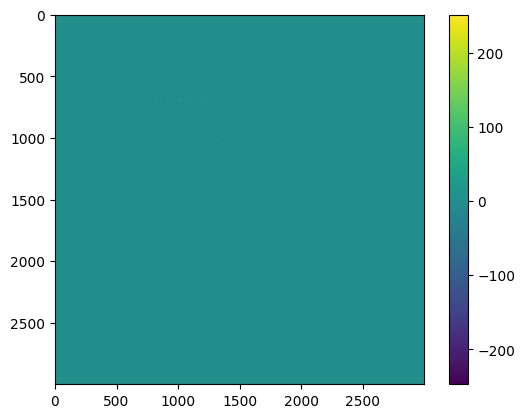

coeff_matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


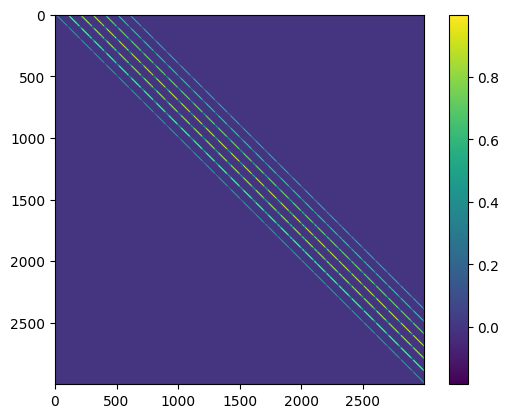

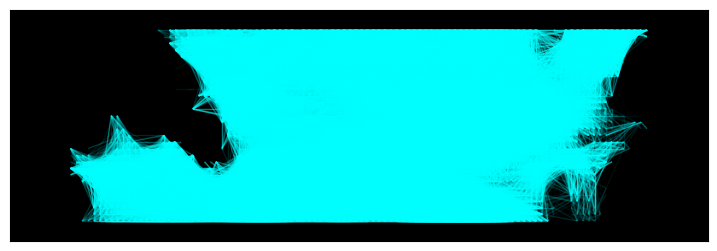

make_network time: 36.57944989204407 seconds


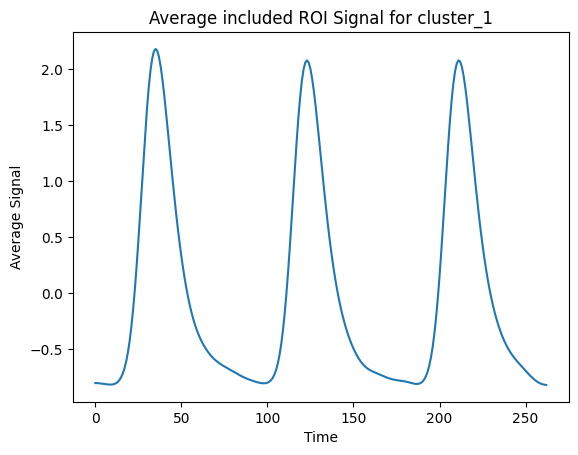

max_coeff: 0
min_coeff: 0
get_pixels time: 91.98074245452881 seconds


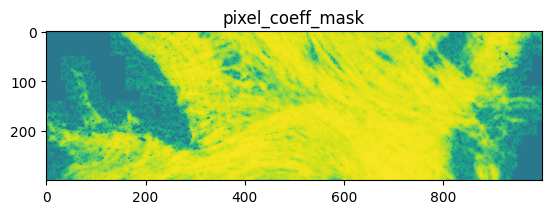

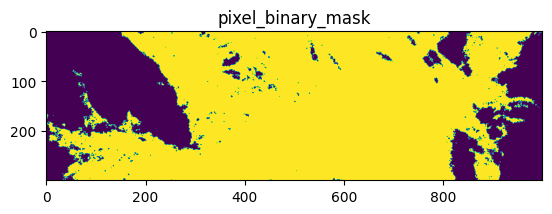

get_cluster_signal time: 1.2268521785736084 seconds
cluster_signal_zs: []


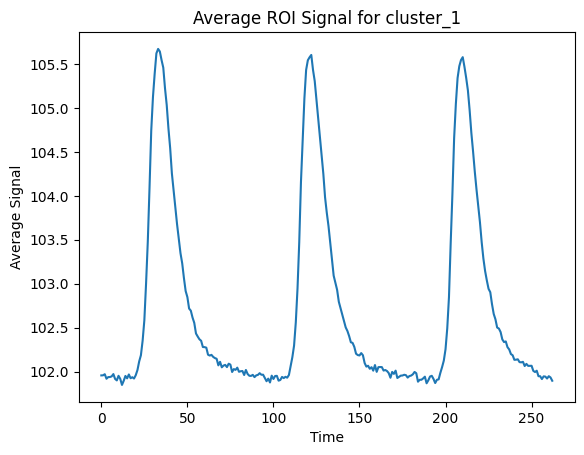

max_pixel_coeff_mask: 0.9681155403309764


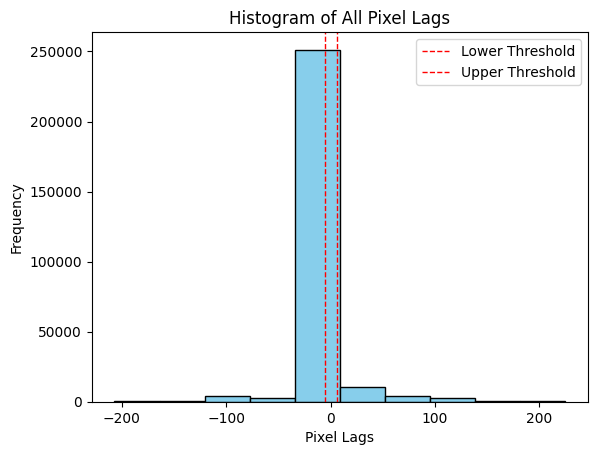

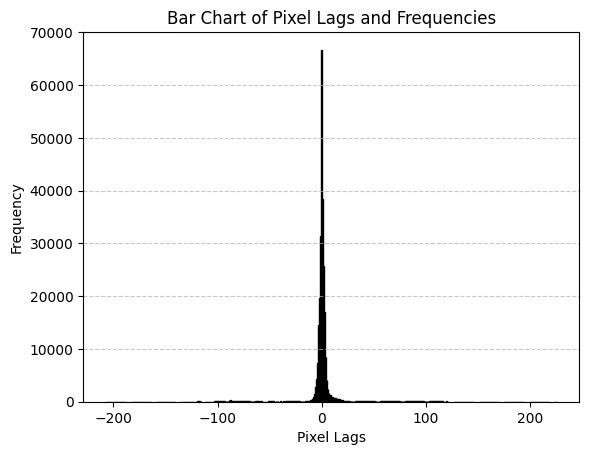

threshold decreased
threshold increased
max_lag: 225
min_lag: -207
max_thresholded_lag: 6.5
min_thresholded_lag: -5.5
lower_threshold: -5.5
upper_threshold: 6.5
lag stndev: 25.994882170031953
all lags: [-15  69 155 ...  -8  -9  -1]
pixel_lag_mask lags: [[ nan  nan  nan ...  4.   4.   4. ]
 [ nan  nan  nan ...  5.   5.   6. ]
 [ nan  nan  nan ...  6.5  6.   6. ]
 ...
 [ 6.5 -5.5 -5.5 ...  nan  nan  nan]
 [ 6.5 -5.5 -5.5 ...  nan  nan  nan]
 [-5.5 -5.5 -5.5 ...  nan  nan  nan]]
get_pixel_lag time: 60.70978832244873 seconds
max pixel lag nan
max pixel norm lag nan
jet


C:\Users\OWNER\AppData\Local\Temp\ipykernel_13816\2494544824.py:251: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = mpl.cm.get_cmap('jet')


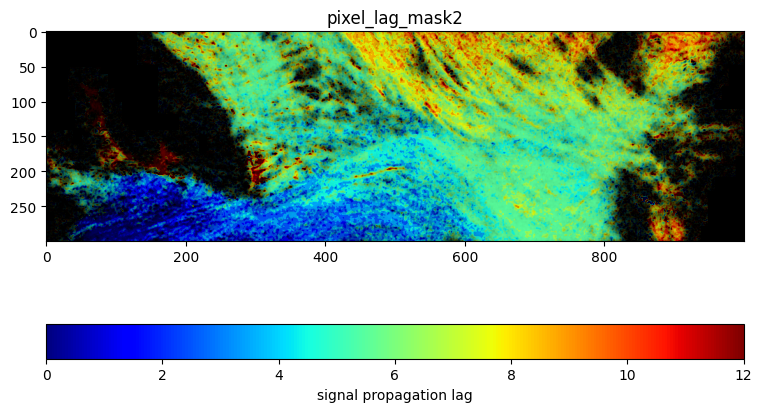

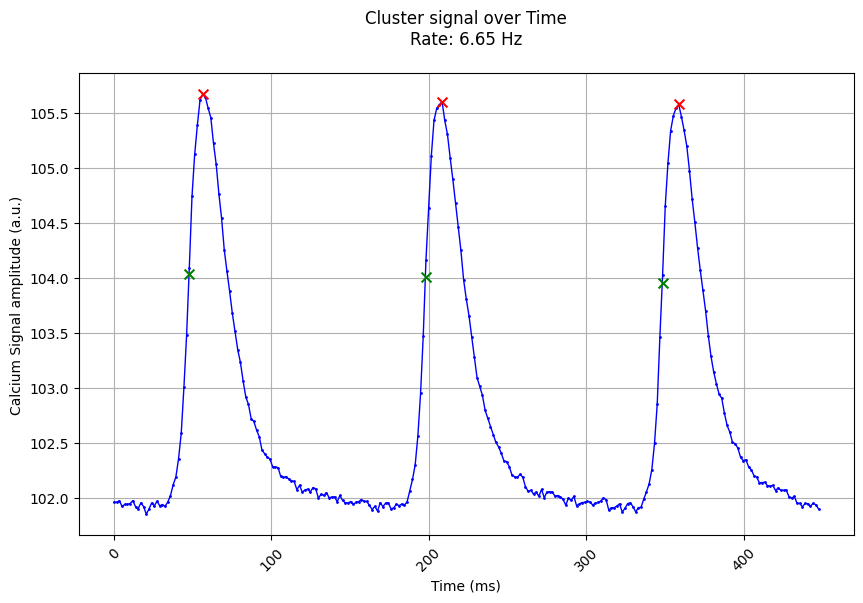

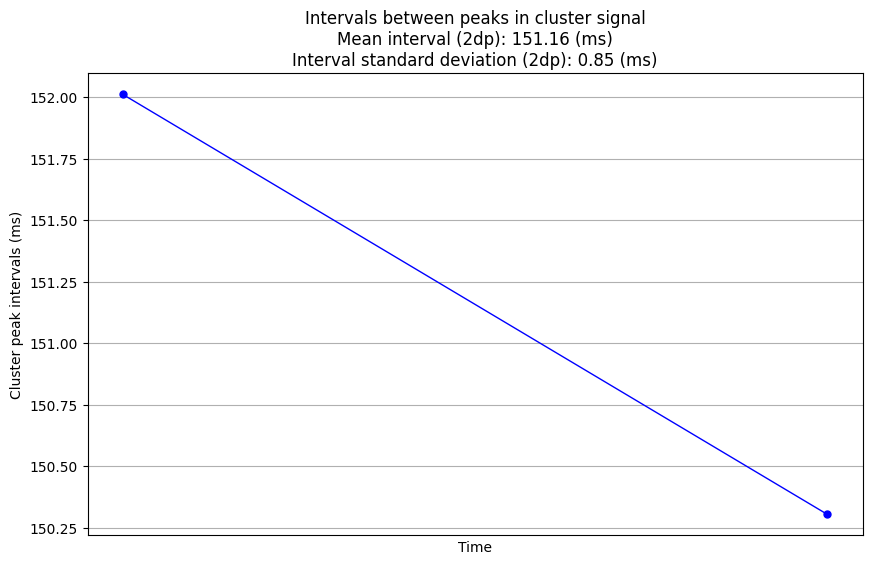

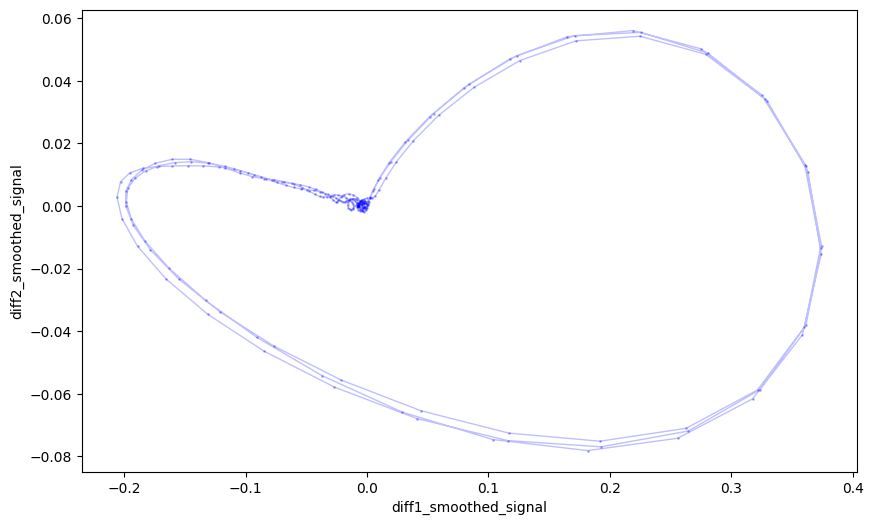

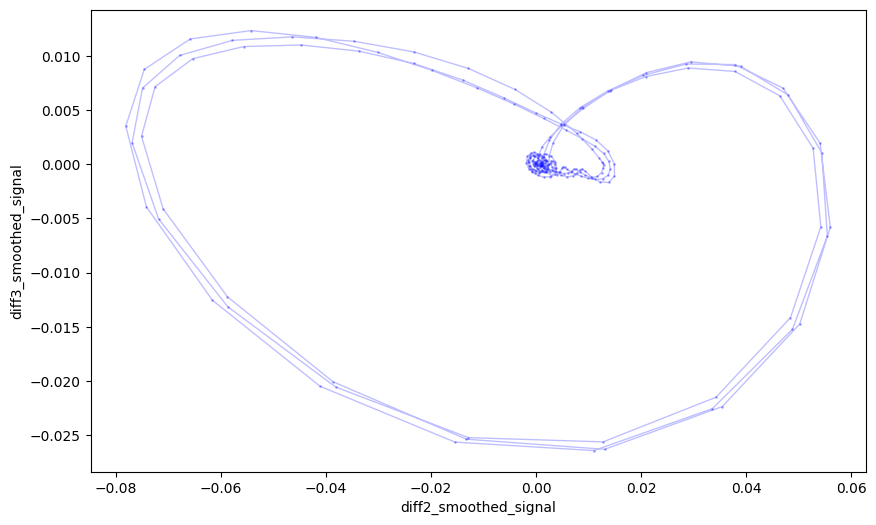

all time: 304.4311571121216 seconds


In [ ]:


# the GUI --- GUI allowing for coherence threshold 0.95-1
selected_file_path_for_analysis = None
        
def gui_browse_files():
    global selected_file_path_for_analysis
    selected_file_path_for_analysis = filedialog.askopenfilename()
    file_name = os.path.basename(selected_file_path_for_analysis)
    if selected_file_path_for_analysis:
        gui_label_file_name.config(text=f"Selected File: {file_name}")
        
def gui_analyse_selected_file():
    global selected_file_path_for_analysis
    if selected_file_path_for_analysis:
        try:
            # gets file
            tiff_image = tifffile.imread(selected_file_path_for_analysis)
            file_name = os.path.basename(selected_file_path_for_analysis)

            # gets roi size
            input_value = gui_entry_roi_size.get()
            if input_value:
                try:
                    roi_size = int(input_value)
                    gui_log_entry(f"ROI size set to: {roi_size}\n")
                except:
                    gui_log_entry("Invalid ROI size. ROI set to default of 10.\n")
                    roi_size = 10
            else:
                gui_log_entry("Invalid ROI size. ROI set to default of 10.\n")
                roi_size = 10
                
            gui_log_entry(f"File name: {file_name}\n")
            gui_log_entry("Processing file...\n")
            analyse(tiff_image, roi_size)
            #if global_data and roi_data:
                #plot_data(tiff_image, roi_size, global_data, roi_data, one_peak_global_data, one_peak_roi_data)
            gui_log_entry("Analysis completed!\n")
        except tifffile.TiffFileError:
            gui_log_entry("Tiff load error.\n")
    else:
        gui_label_file_name.config(text="Selected File: no file selected.")
        gui_log_entry("DANGER WILL ROBINSON NO FILE HAS BEEN SELECTED!\n")

root = tk.Tk()
root.title("The Cardio-Tographer")

gui_label_frame_title = tk.Frame(root)
gui_label_frame_title.pack(pady=10)
gui_label_title_one = tk.Label(gui_label_frame_title, text="The", font=("Arial", 8, "bold"), fg="black")
gui_label_title_one.pack(side="left", padx=(5, 0))
gui_label_title_two = tk.Label(gui_label_frame_title, text="Cardio", font=("Arial", 24, "bold"), fg="blue")
gui_label_title_two.pack(side="left", padx=(0, 0))
gui_label_title_three = tk.Label(gui_label_frame_title, text="Tographer", font=("Arial", 12, "italic"), fg="green")
gui_label_title_three.pack(side="left", padx=(0, 5))

gui_label_file_name = tk.Label(root, text="Selected Tiff File: ", font=("Arial", 10))
gui_label_file_name.pack(pady=5)

gui_button_browse = tk.Button(root, text="Browse", font=("Arial", 10), command=gui_browse_files)
gui_button_browse.pack(pady=5)

gui_button_analyse = tk.Button(root, text="Start analysis", font=("Arial", 10), command=gui_analyse_selected_file)
gui_button_analyse.pack(pady=5)

gui_label_frame_roi_size = tk.Frame(root)
gui_label_frame_roi_size.pack(pady=10)
gui_label_roi_size = tk.Label(gui_label_frame_roi_size, text="Enter ROI Size:", font=("Arial", 10))
gui_label_roi_size.pack(side="left", padx=(5, 0))
gui_entry_roi_size = tk.Entry(gui_label_frame_roi_size, font=("Arial", 10), width=10)
gui_entry_roi_size.pack(side="left", padx=(0, 5))

def gui_log_entry(text):
    gui_log.config(state=tk.NORMAL)
    gui_log.insert(tk.END, text)
    gui_log.config(state=tk.DISABLED)
    root.update()

gui_log = tk.Text(root, height=10, width=80)
gui_log.pack(pady=10, padx=10)
gui_log.config(state=tk.DISABLED)

root.mainloop()